In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot
import seaborn as sns
import os
import tqdm
from typing import List, Union

import warnings 
warnings.filterwarnings('ignore')

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    roc_curve,
    auc,
)

# model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# imbalance learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [3]:
palette = [ '#0077b6' , '#00b4d8' , '#90e0ef' , '#caf0f8']
# color_palette = sns.color_palette(palette)
sns.set_palette(palette)
sns.set_style('whitegrid')

# Bank Churn - Binary Classification Problem
- Goal: to predict whether a customer continues with their account or closes it (e.g., churns)
- Metrics: Area Under the ROC curve between the predicted probability and the observed target.
- `Dataset`: [Link](https://www.kaggle.com/competitions/playground-series-s4e1/data)
- Similar Dataset:
    - Telco Customer Churn
    - Bank Customer Churn Dataset
    - Telecom Churn Dataset
    - Internet Service Provider Customer Churn

- Exp 1: No Upsampling, No scale -> XGBoost, RandomForest, LightGBM
- Exp 2: No Up-sampling, Scale -> Logistic, XGBoost, Random Forest, LightGBM
- Exp 2: Up-sampling (SMOTE), No scale -> XGBoost, RandomForest, LightGBM
- Exp 3: Up-sampling (SMOTE), Scale -> Logistic (logestic only works best on balance dataset & scaled), XGBoost, Random Forest, LightGBM

- Encoding:
    - Multiple cardinals: Hasing Encoder

## Basic Exploration
`Columns Description:`

- *`Customer ID:` A unique identifier for each customer*
- *`Surname:` The customer's surname or last name*
- *`Credit Score:` A numerical value representing the customer's credit score*
- *`Geography:` The country where the customer resides (France, Spain or Germany)*
- *`Gender:` The customer's gender (Male or Female)*
- *`Age:` The customer's age.*
- *`Tenure:` The number of years the customer has been with the bank*
- *`Balance:` The customer's account balance*
- *`NumOfProducts:` The number of bank products the customer uses (e.g., savings account, credit card)*
- *`HasCrCard:` Whether the customer has a credit card (1 = yes, 0 = no)*
- *`IsActiveMember:` Whether the customer is an active member (1 = yes, 0 = no)*
- *`EstimatedSalary:` The estimated salary of the customer*
- *`Exited:` Whether the customer has churned (1 = yes, 0 = no)*

### Data Loading

In [4]:
df = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv", index_col=0)
df_test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv", index_col=0)
submission_data = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

### Quick Overview

In [5]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
df.shape, df_test.shape

((165034, 13), (110023, 12))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


#### Missing Values

In [8]:
# Null Values in Train 
train_null = df.isnull().sum().sum()

#Null Count in Test 
test_null = df_test.isnull().sum().sum()

print(f'Null Count in Train: {train_null}')
print(f'Null Count in Test : {test_null}')

Null Count in Train: 0
Null Count in Test : 0


In [9]:
df.isna().sum()*100 / df.shape[0]

CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

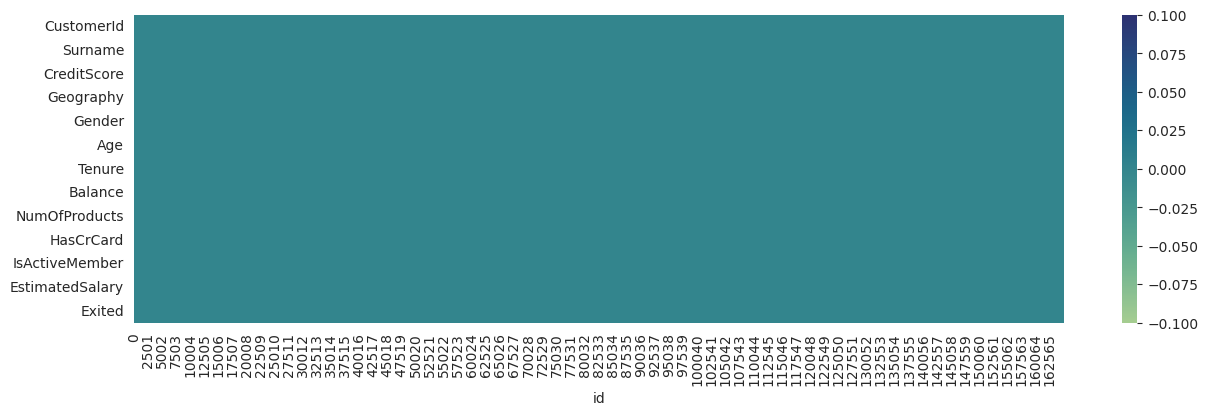

In [10]:
#Showing missing data at which index of the data
fig, ax = plt.subplots(figsize=(15,4)) 
sns.heatmap(df.isna().transpose(), ax=ax, cmap="crest")
plt.show()

#### Duplicates Values 

In [11]:
# Count duplicate rows in train_data
train_duplicates = df.duplicated().sum()
test_duplicates = df.duplicated().sum()

# Print the results
print(f"Number of duplicate rows in df_train: {train_duplicates}")
print(f"Number of duplicate rows in df_test: {test_duplicates}")

Number of duplicate rows in df_train: 0
Number of duplicate rows in df_test: 0


#### Numercial & Catergorical Column Identification

In [12]:
df.nunique().sort_values(ascending=False)

EstimatedSalary    55298
Balance            30075
CustomerId         23221
Surname             2797
CreditScore          457
Age                   71
Tenure                11
NumOfProducts          4
Geography              3
Gender                 2
HasCrCard              2
IsActiveMember         2
Exited                 2
dtype: int64

- `CustomerId` and `Surname` has a significant number of unique values, but they are really not helpful in building the ML Models, hence we will drop those columns

In [13]:
df = df.drop(['CustomerId', 'Surname'], axis=1)
df_test = df_test.drop(['CustomerId', 'Surname'], axis=1)

In [39]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
        df: dataframe contains only catergorical features
    """
    data = [[df[c].unique().to_list(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]


def find_categorical(df, cutoff=12):
    """
        Function to find categorical columns in the dataframe.
        cutoff: is determinied when plotting the histogram distribution for numerical cols
    """
    cat_cols = []
    for col in df.columns:
        if len(df[col].unique()) <= cutoff:
            cat_cols.append(col)
    return cat_cols

def to_categorical(cat_cols, df):
    """
        Converts the columns passed in `columns` to categorical datatype for keras model
    """
    for col in cat_cols:
        df[col] = df[col].astype('category')
    return df

In [15]:
cat_cols = find_categorical(df)
df = to_categorical(cat_cols, df) # to convert cat column into category 

In [16]:
num_cols = list(set(df.columns) - set(cat_cols))

In [17]:
print(f'Numerical Columns : {num_cols}')
print(f'Categorical Columns: {cat_cols}')

Numerical Columns : ['EstimatedSalary', 'CreditScore', 'Age', 'Balance']
Categorical Columns: ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']


In [38]:
df["Geography"].unique().to_list()

['France', 'Spain', 'Germany']

In [40]:
summarize_categoricals(df[cat_cols], show_levels=True)

,Levels,No. of Levels,No. of Missing Values
Geography,"[France, Spain, Germany]",3,0
Gender,"[Male, Female]",2,0
Tenure,"[3, 1, 10, 2, 5, 4, 8, 6, 9, 7, 0]",11,0
NumOfProducts,"[2, 1, 3, 4]",4,0
HasCrCard,"[1.0, 0.0]",2,0
IsActiveMember,"[0.0, 1.0]",2,0
Exited,"[0, 1]",2,0


## EDA

### Univariate Analysis

#### Numerical Cols

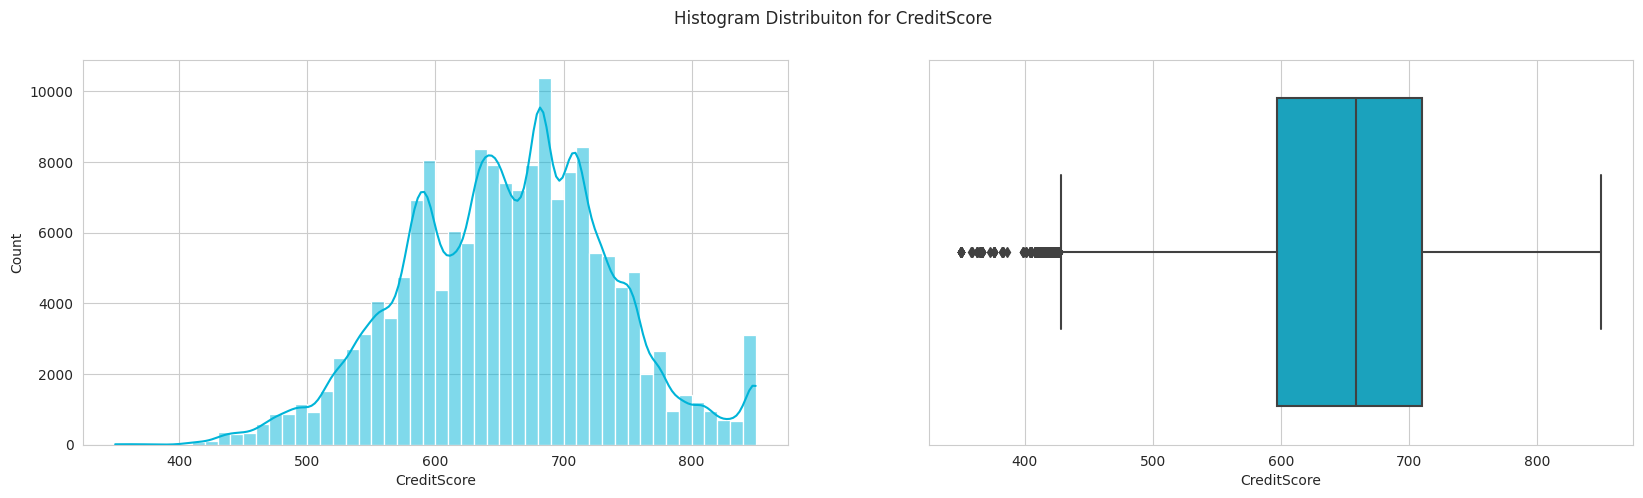

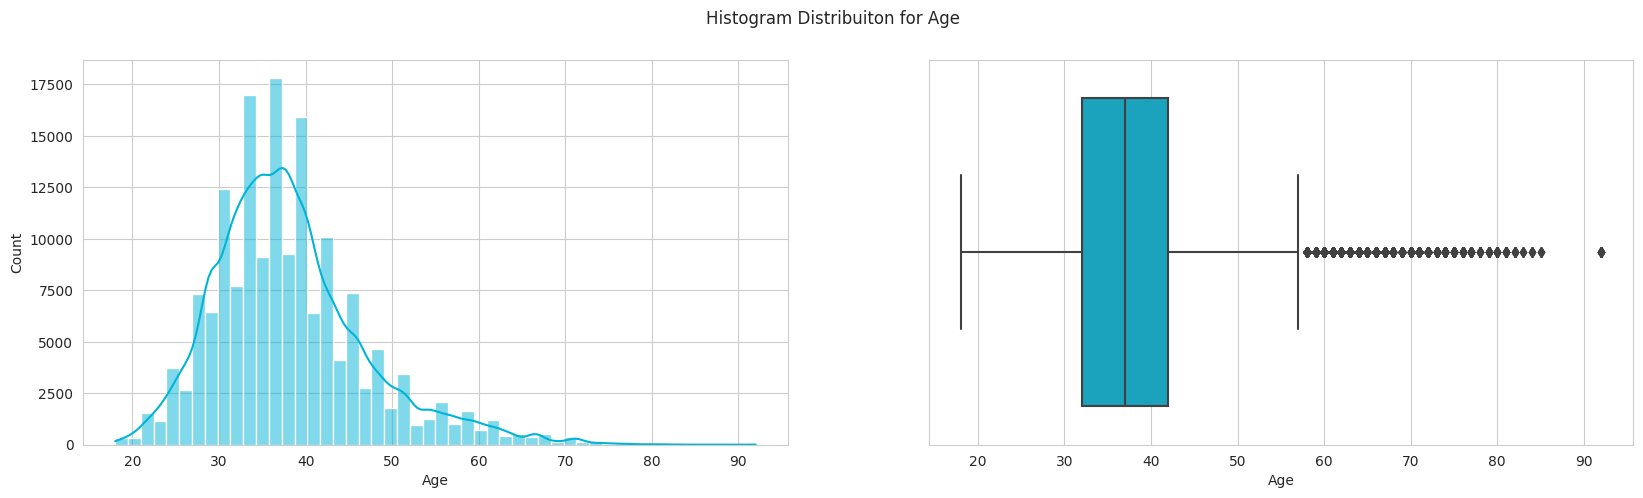

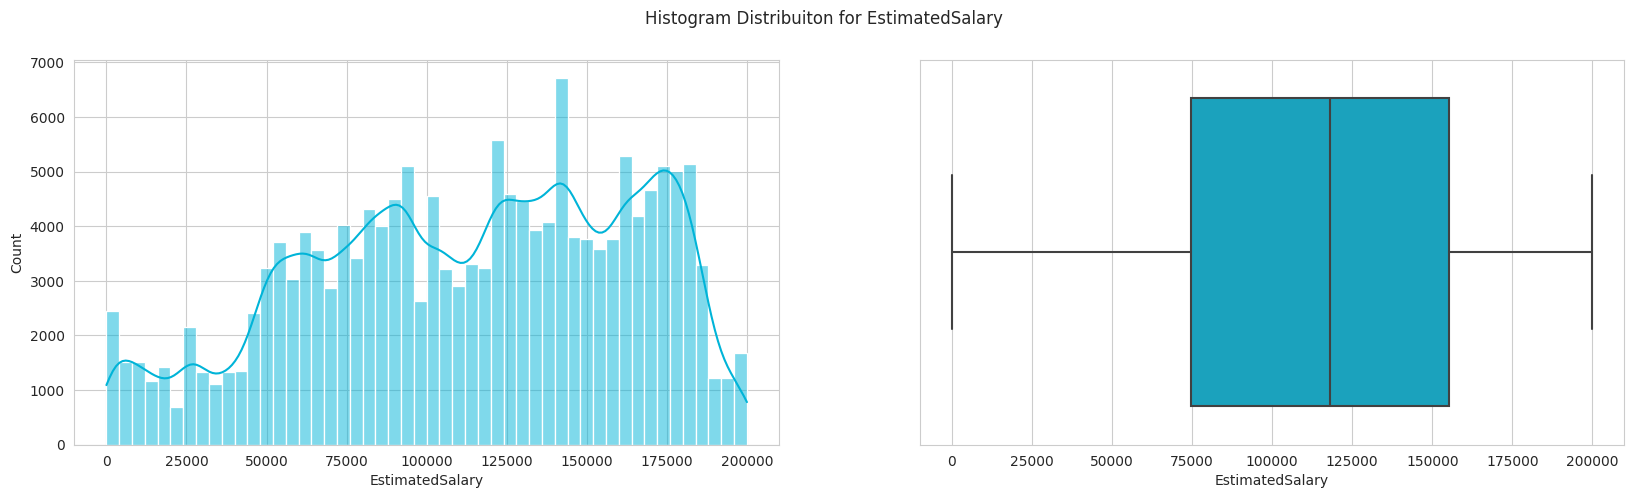

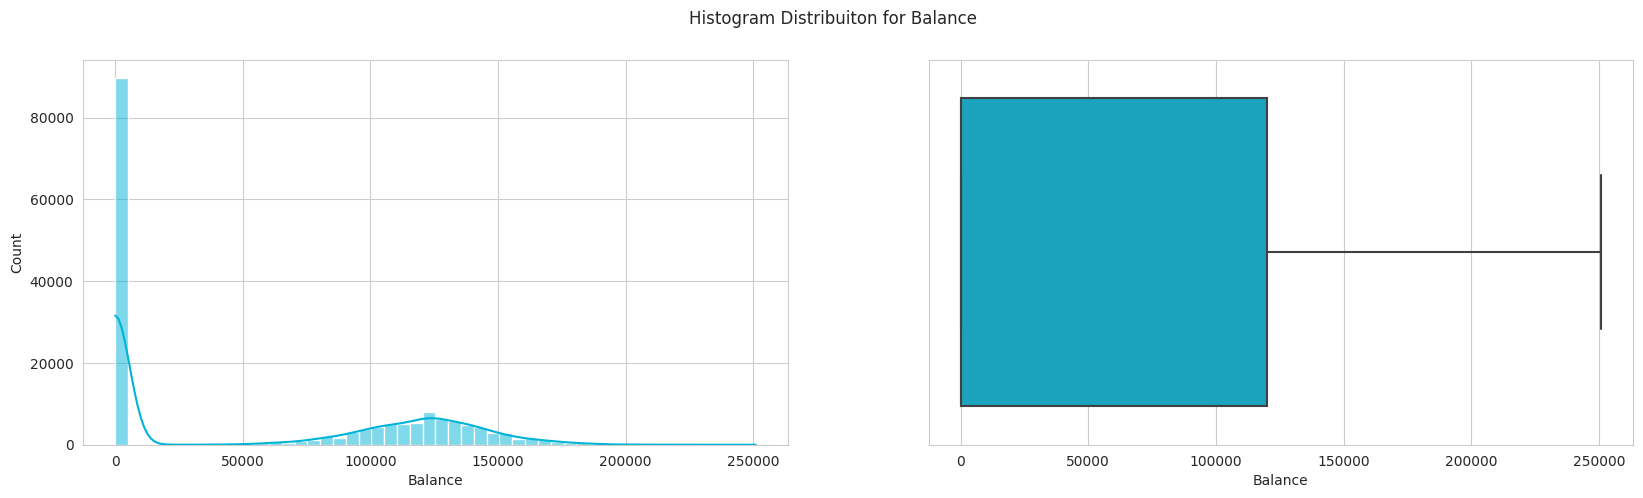

In [18]:
for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(f"Histogram Distribuiton for {col}")
    sns.histplot(data=df, x=col, bins=50, kde=True, color=palette[1], ax=ax[0])  
    sns.boxplot(x=df[col], ax=ax[1], palette=palette[1:])

Observation:
- Outliers: `Age`, `Credit Score`
- Majority of the data from `Balance` variable is 0 only which makes the distribution skewed to 0 side.

#### Categorical Cols

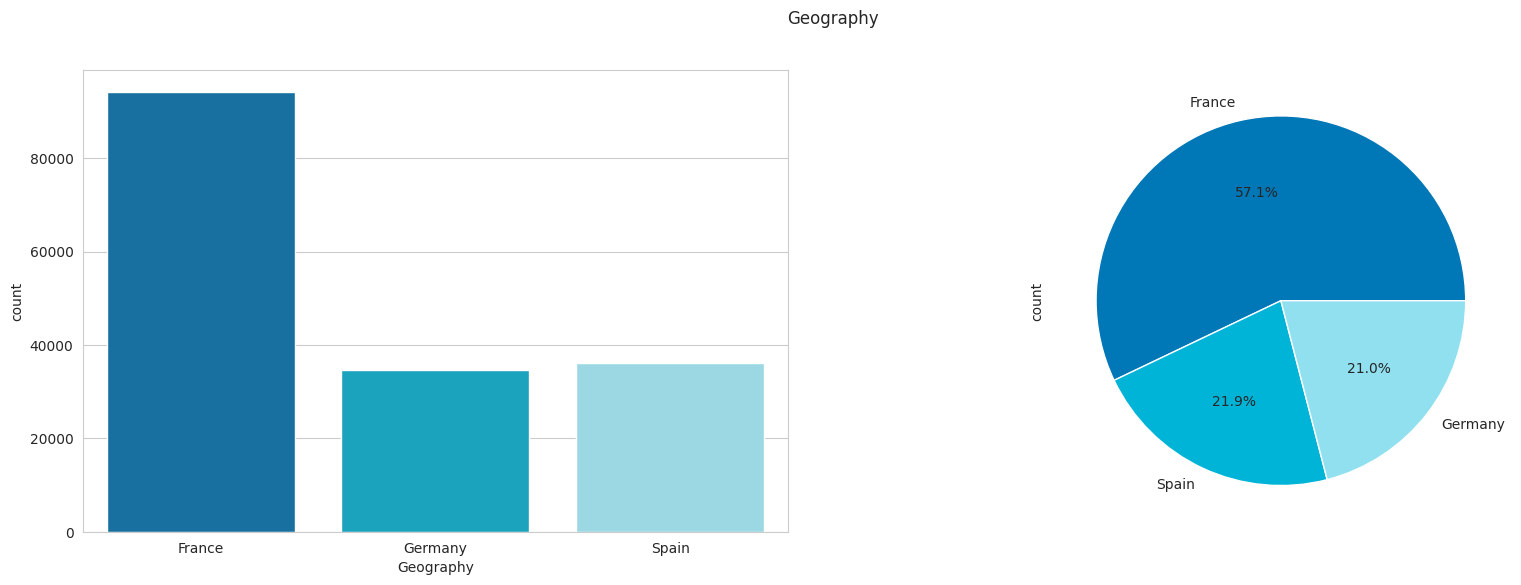

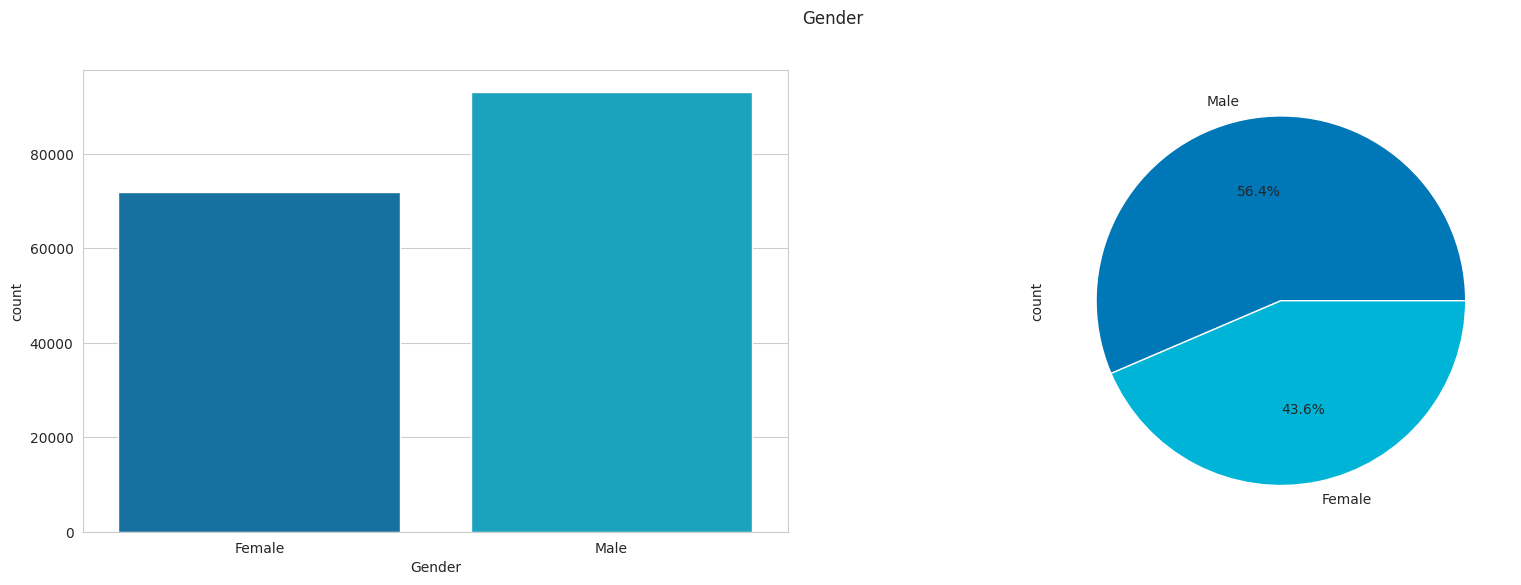

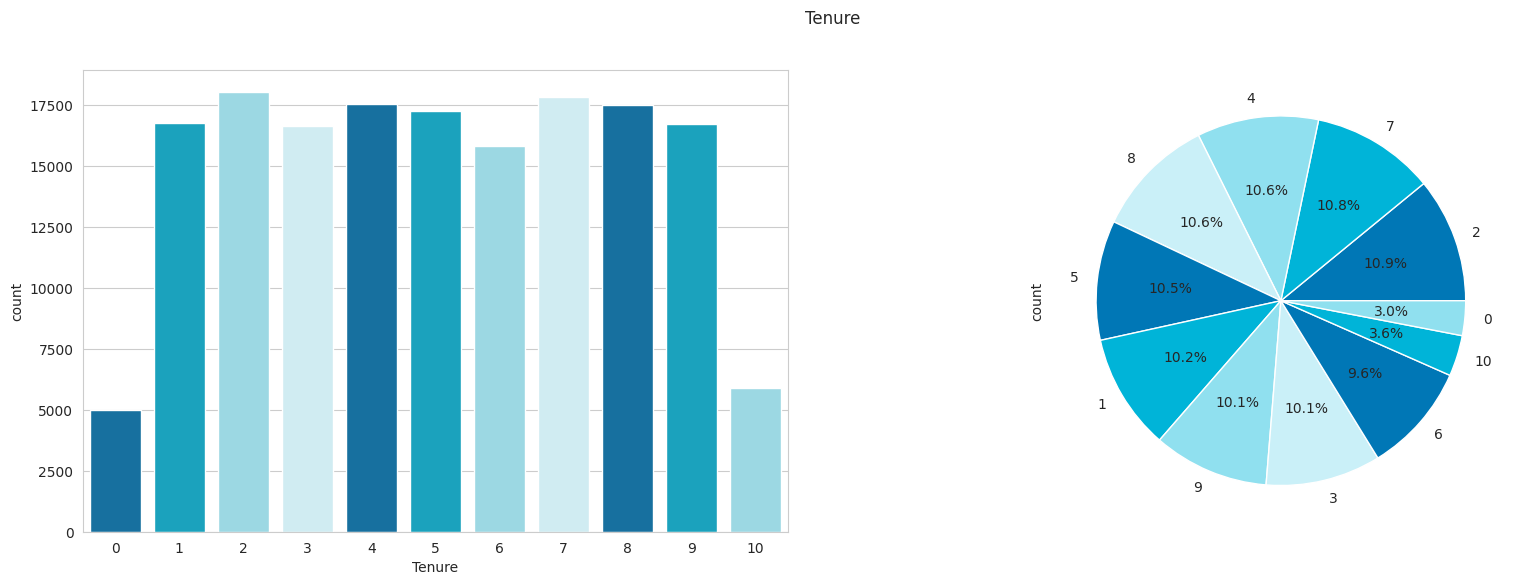

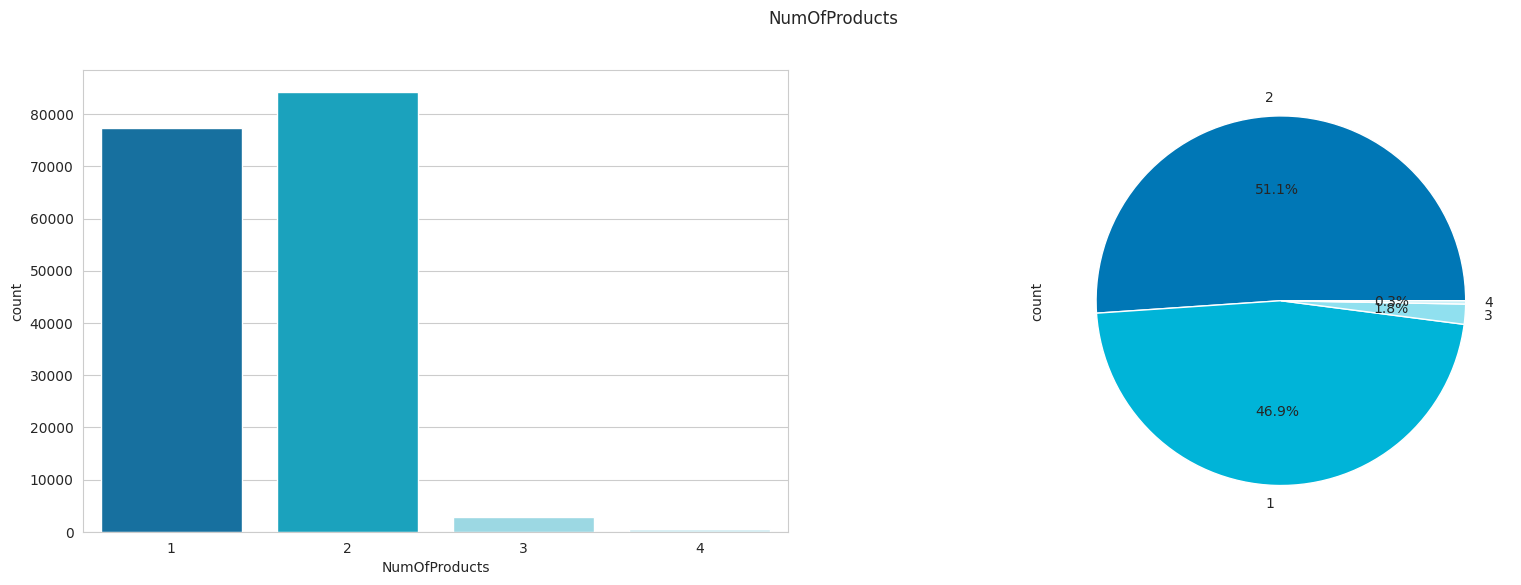

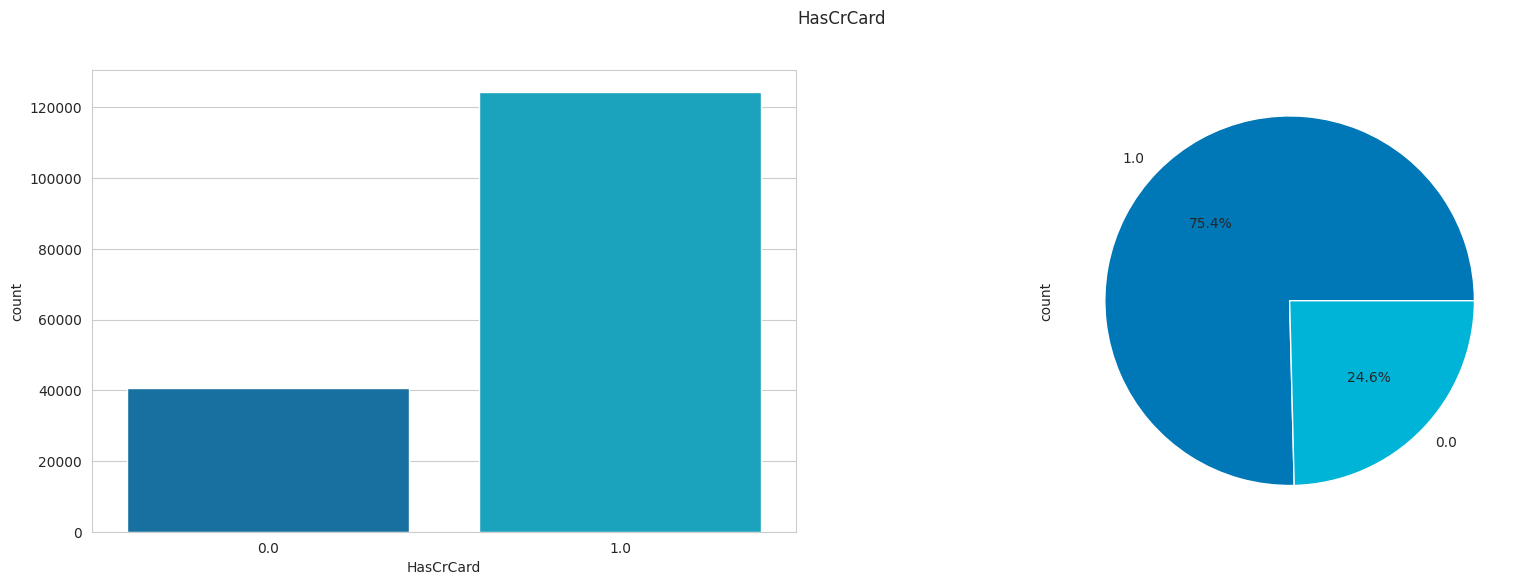

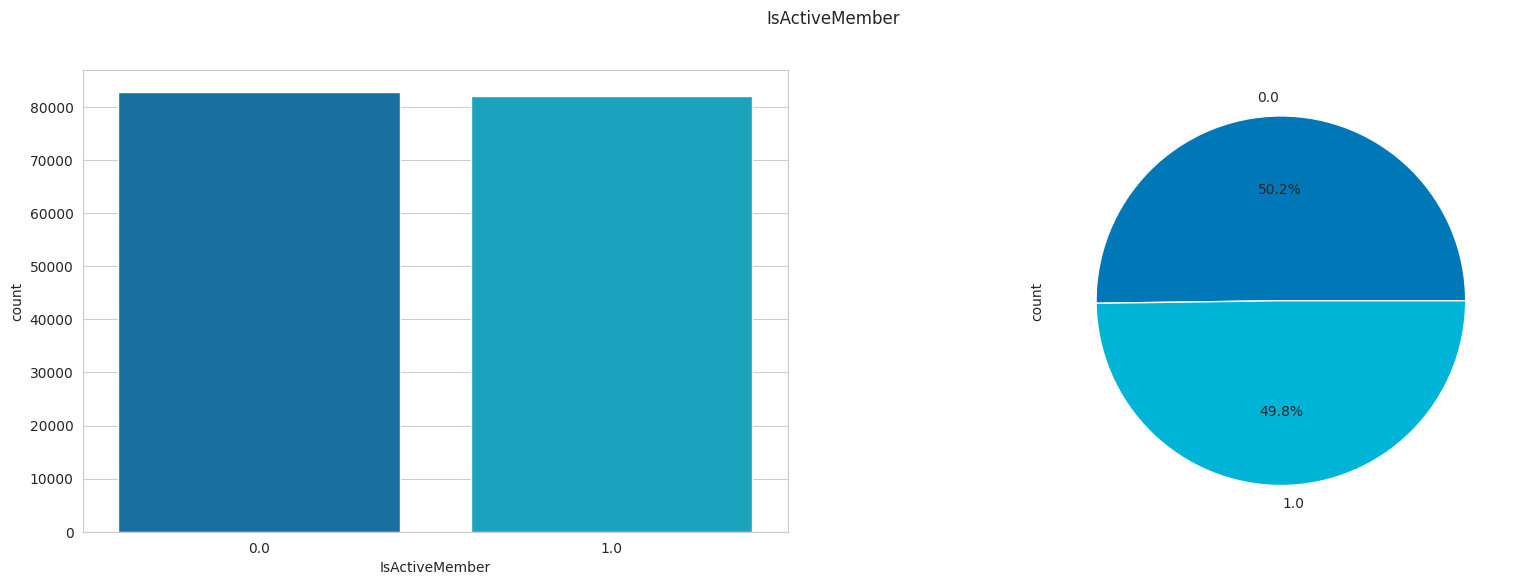

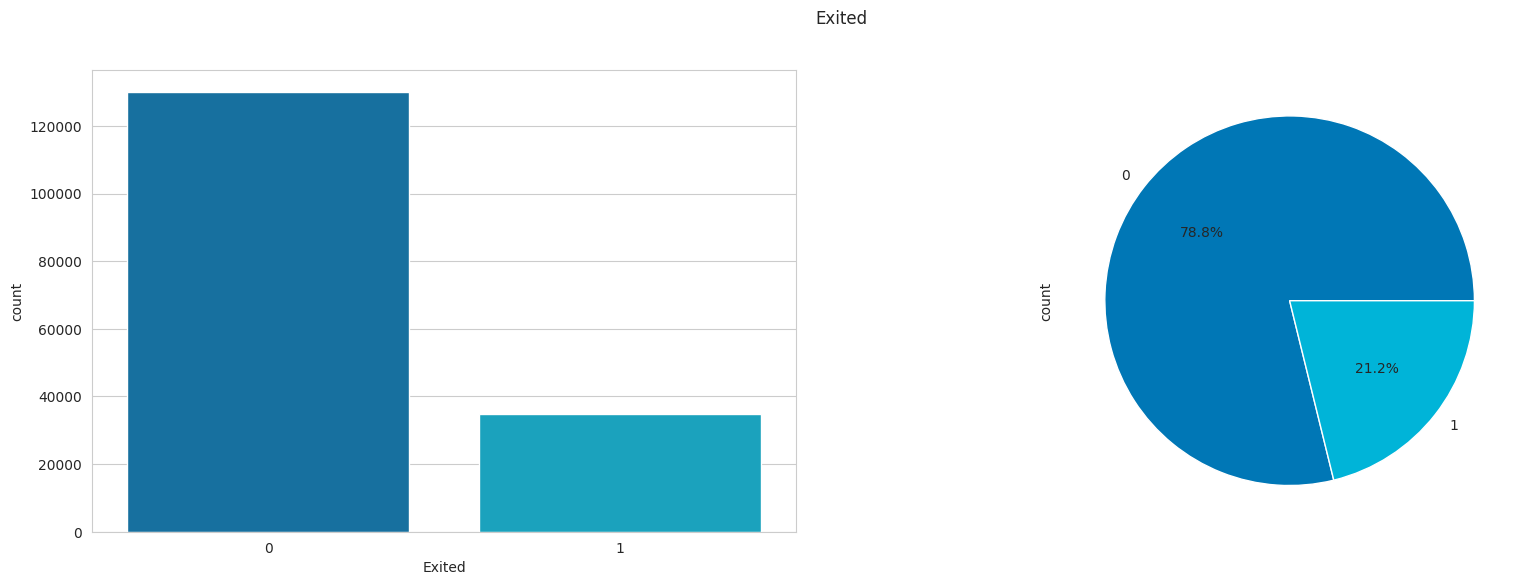

In [19]:
for column in cat_cols:
    fig, ax=plt.subplots(1,2,figsize=(20,6))
    
    df[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],  colors=palette)
    sns.countplot(x=column, data=df, ax=ax[0], palette=palette)
    
    fig.suptitle(f'{column}')
    plt.show()

- The variables such as `IsActiveMember`, `Tenure` are almost equaly distributed 
- While the other variables like `HasCrCard`, `NumOfProducts`, and `Gender` are not equaly distributed.
- `Tenure`, at first, seems like continuous variable but it is a categorical variable with 11 classes from 0 to 10.
- The target variable `Exited` also has an imbalance distribution between class 0 and class 1


### Bi-Variate Analysis

#### Correlation between Quantitative Variables
- Quantitative Variables include catergorical variables which are numeric

In [20]:
quantitative_variables = df.select_dtypes(include=np.number).columns.to_list()
print(quantitative_variables)

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


In [21]:
corr_df = df[quantitative_variables].corr()

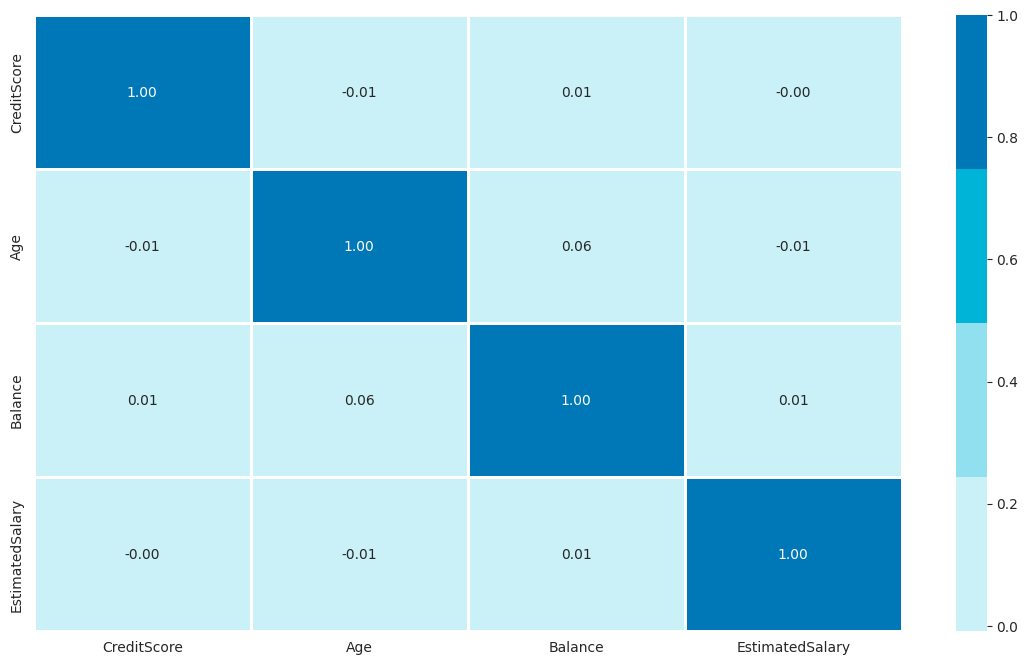

In [22]:
plt.figure(figsize= (14, 8))
sns.heatmap(corr_df, annot = True, fmt = '.2f', linewidths= 0.8  , cmap= palette[::-1])
plt.show()

- There is a positive correlation between the `Age` and the `Exited`, which means that when the age is larger, the churn probability is larger

##### Collinear Feature Removal

In [23]:
def remove_collinear_features(df, 
                              quantitative_variables, 
                              target_column,
                              threshold = 0.99):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        df: original dataframe
        quantitative_variables: list of quantitative variables
        target_column: this to ignore the target_column as this function is to remove col-linear among features
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    x = df[quantitative_variables]
    x = x.drop(target_column, axis=1)
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(f"({col.values[0]:15s} | {row.values[0]:15s} | {round(val[0][0], 2)}) -> Remove '{col.values[0]}'")
                drop_cols.append(col.values[0])

    
    drops = set(drop_cols)
    # Drop one of each pair of correlated columns in the original df 
    df = df.drop(columns=drops, axis=1)

    return df

# remove_collinear_features(df, quantitative_variables, target_column="Exited", threshold=0.3)

#### Features vs Target Variables

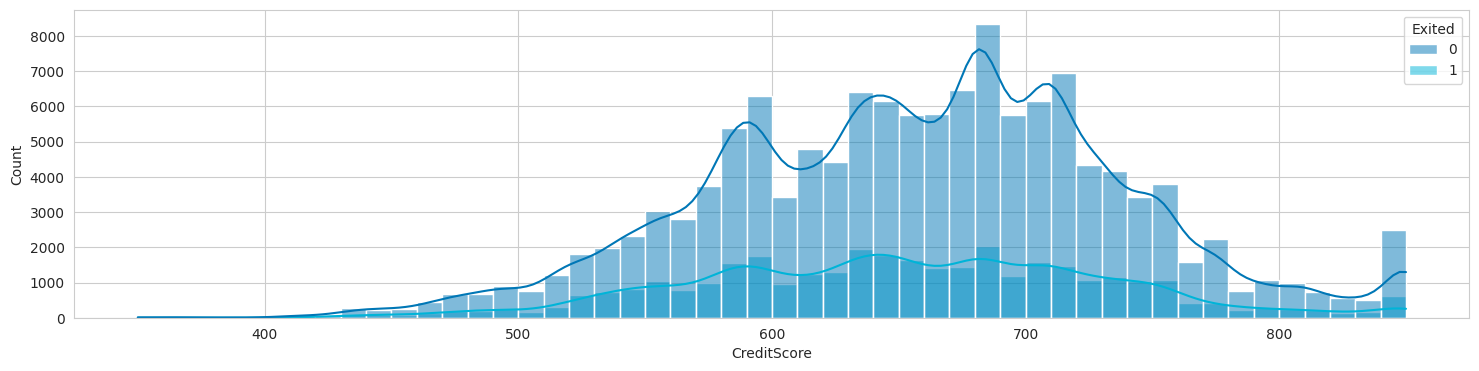

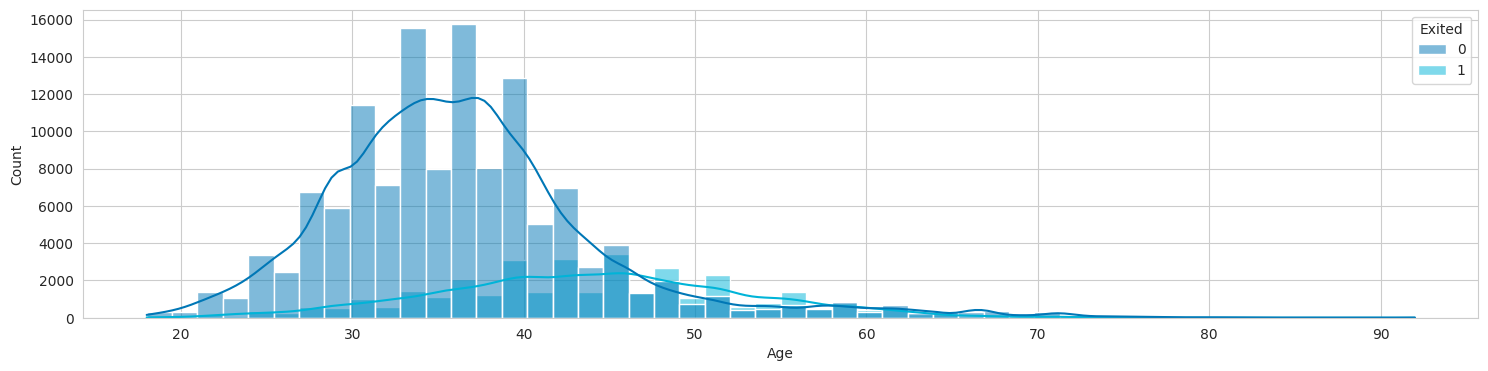

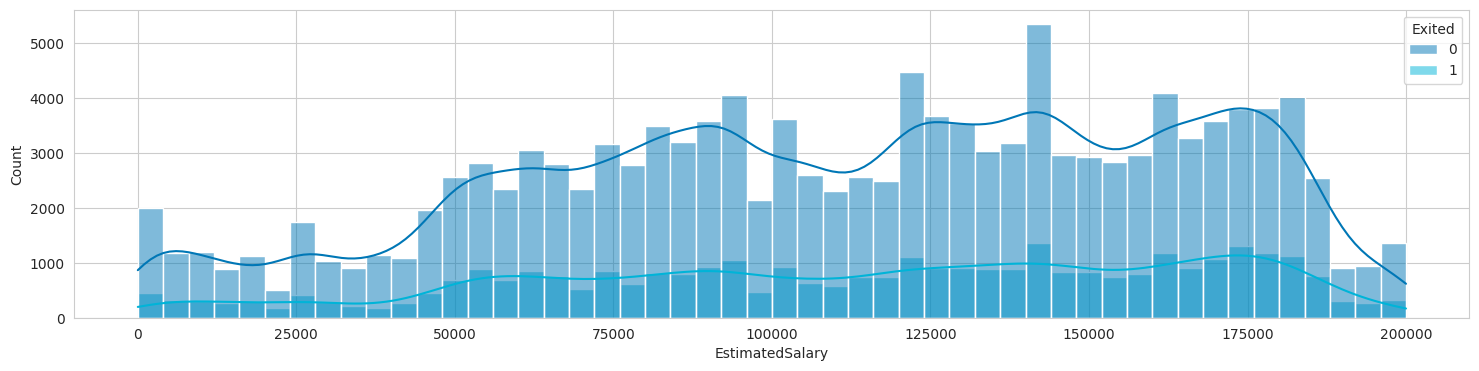

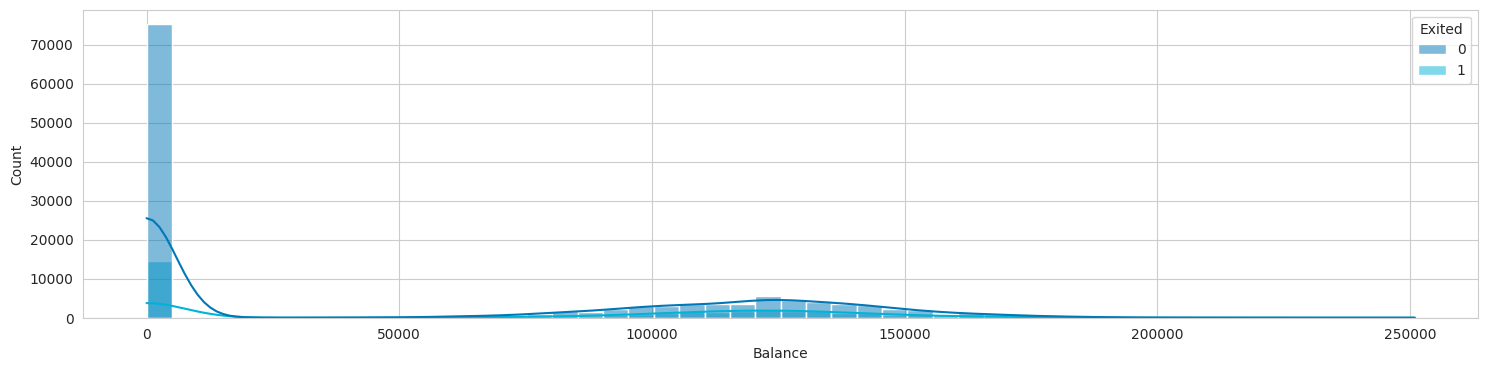

In [24]:
for column in num_cols:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=df, x=column, hue="Exited", bins=50, kde=True  ,palette=palette)
    plt.show()

- Distribution of data for both classes is almost same for all the variables, except `Age` where the churn group has the mean age around 40-50, while the non-churn group centers around 30-40

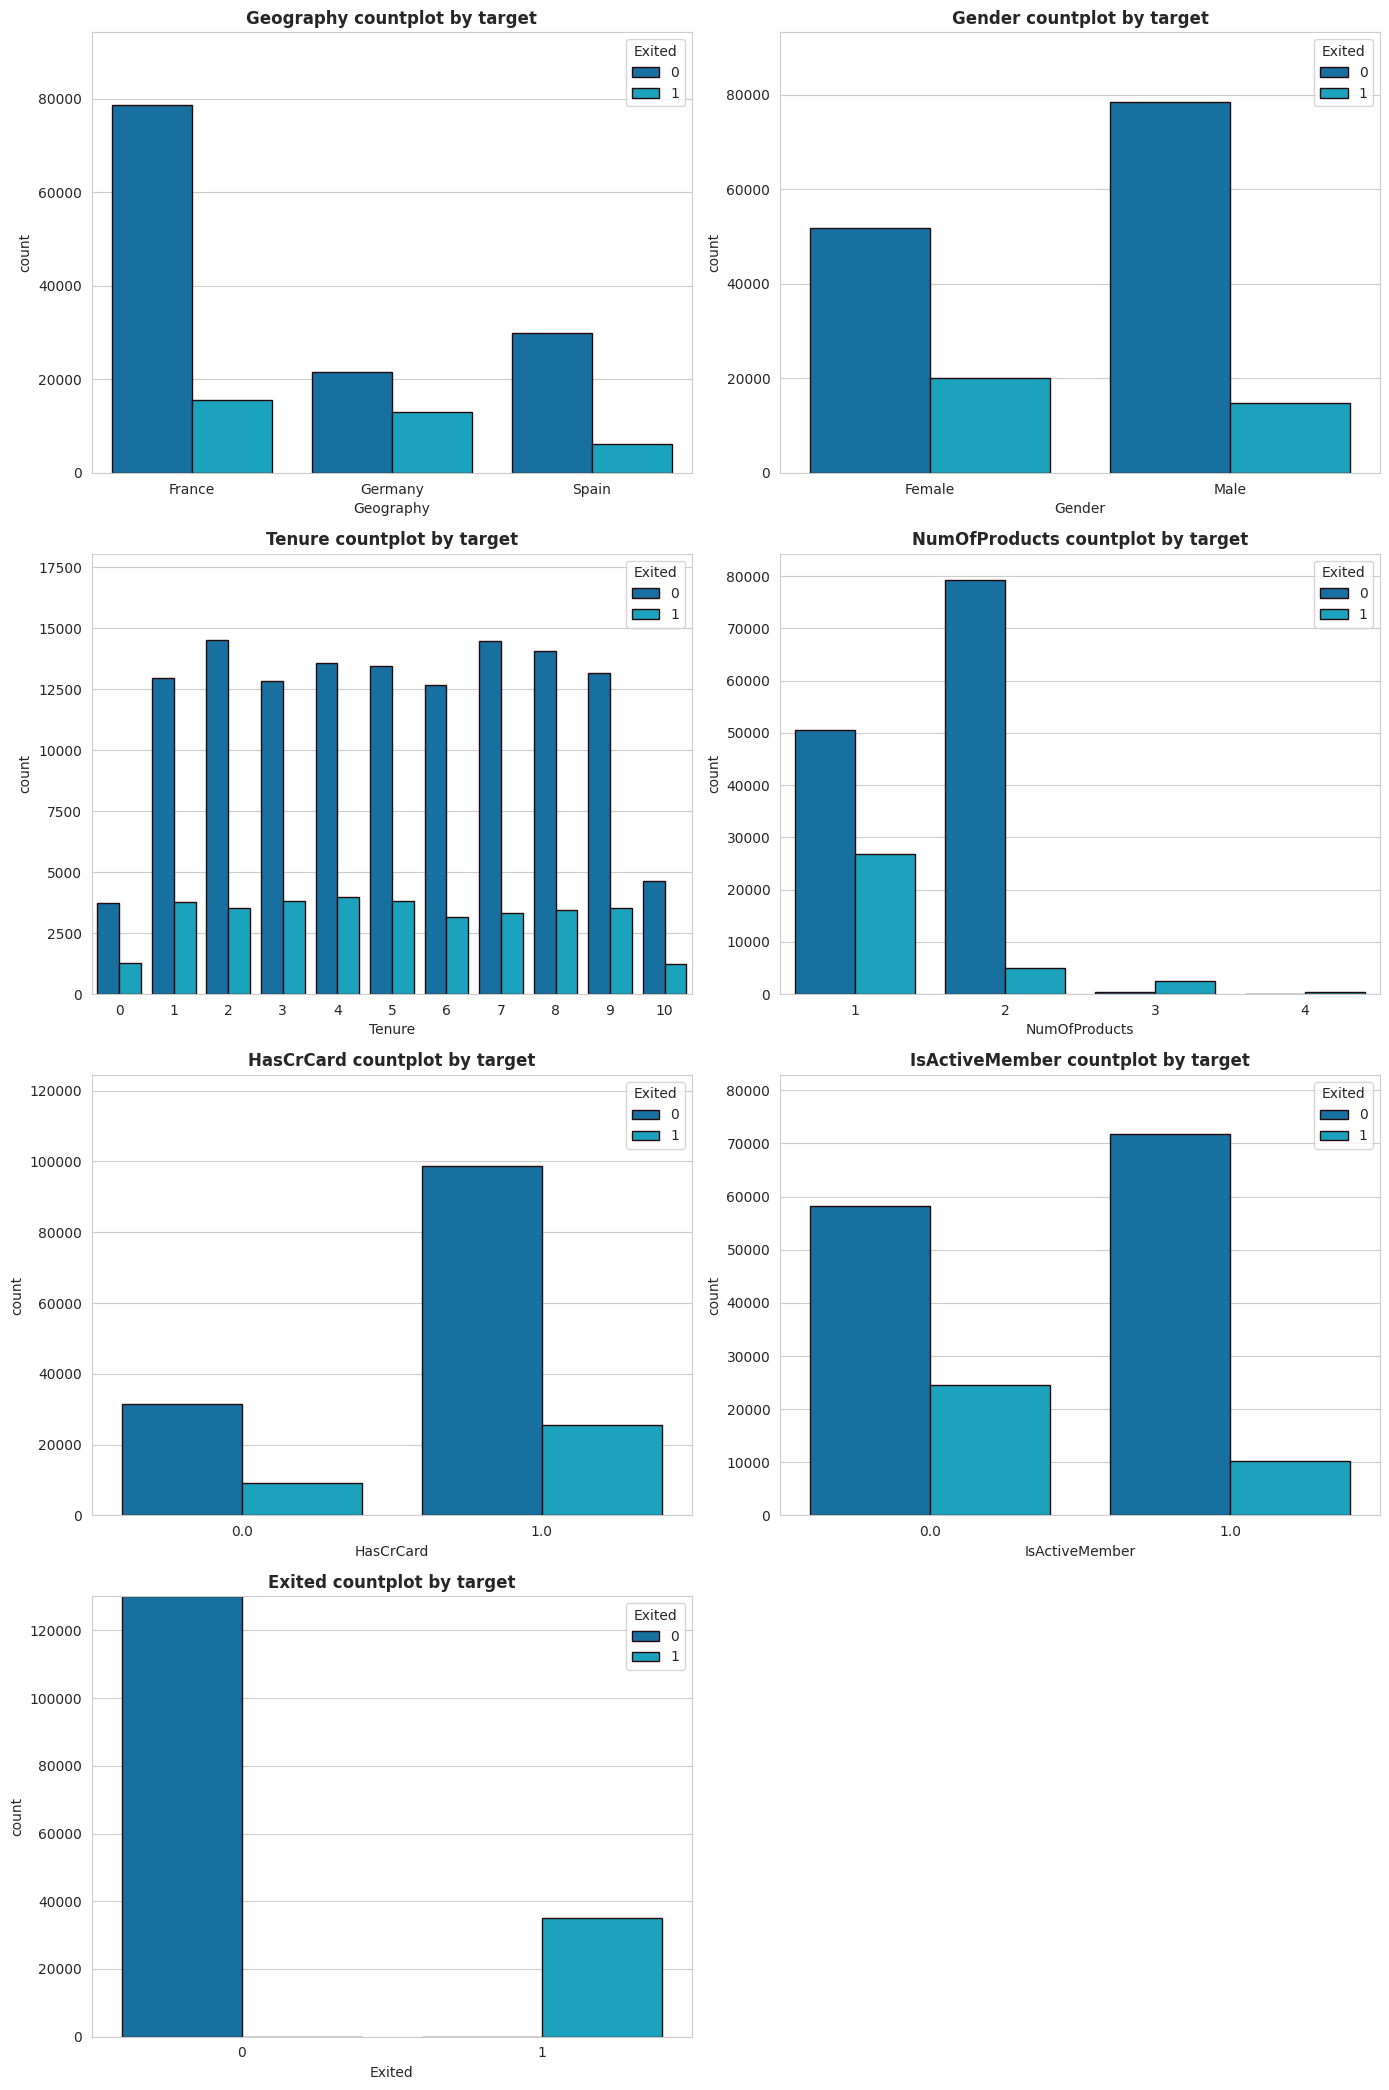

In [25]:
fig = plt.figure(figsize=(14, len(cat_cols)*3))

for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue='Exited', data=df, palette=palette[0:2], color='#26090b', edgecolor='#26090b')
    plt.title(f"{col} countplot by target", fontweight = 'bold')
    plt.ylim(0, df[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

In [26]:
# sns.pairplot(df[[*num_cols, "Exited"]], hue="Exited", corner=True, palette=palette)
# plt.show()

## Feature Engineering

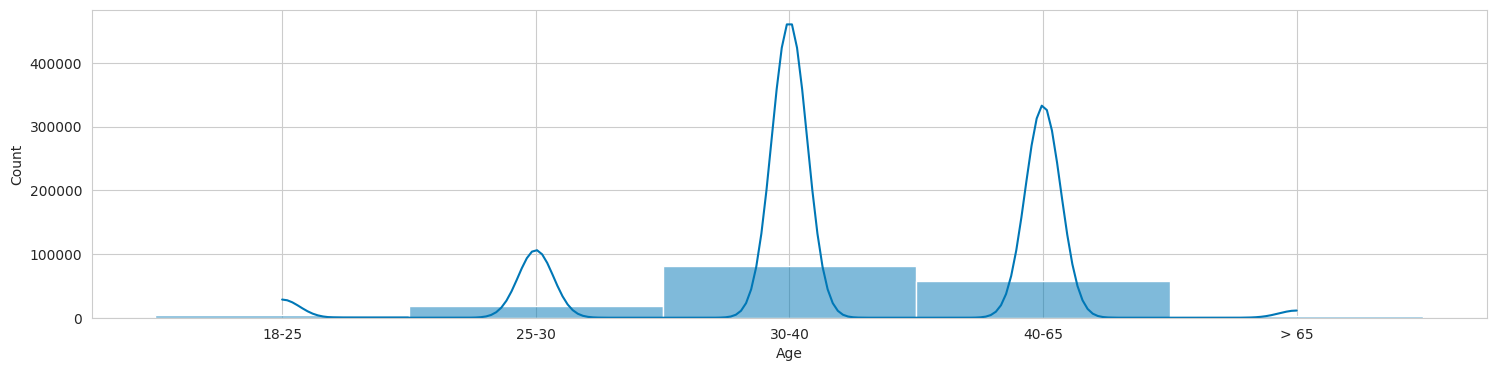

In [27]:
# extra code – just shows that we get a uniform distribution
# percentiles = [np.percentile(df["Age"], p)
#                for p in [5, 25, 50, 75, 95]]

age_bins = [0, 18, 25, 30, 40, 65, np.inf]  # Adjust the bin edges as needed
age_labels = ['0-18', '18-25', '25-30', '30-40', '40-65', '> 65']

# Bin the Age column
age_bin_df = pd.cut(df[['Age']].iloc[:, 0], bins=age_bins, labels=age_labels, right=False)

fig, ax = plt.subplots(figsize=(18, 4))
fig = sns.histplot(data=age_bin_df, kde=True, palette=palette)
plt.show()

## Transformation Pipeline

In [28]:
X = df.drop(columns='Exited')
y = df['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

### Custom Transformers


#### `FunctionTransformer`
- The `inverse_func` argument is optional.
- Custom transformers are also useful to combine features.
- `FunctionTransformer` is very handy, but what if you would like your transformer to be trainable, learning some parameters in the `fit()` method and using them later in the `transform()` method? For this, you need to write a **custom class**. 

In [29]:
def bin_feature(X, bins, labels):
     # This function takes a 1D array X and -> convert X's into category
    return pd.DataFrame(pd.cut(X.iloc[:, 0], bins=bins, labels=labels, right=False), columns=X.columns).astype('category')

age_bins = [0, 18, 25, 30, 40, 65, np.inf]  # Adjust the bin edges as needed
age_labels = ['0-18', '18-25', '25-30', '30-40', '40-65', '> 65']
fe_age =  FunctionTransformer(bin_feature, 
                              kw_args={"bins": age_bins, "labels": age_labels}, #provide the arguments to "bin_feature" function
                              feature_names_out="one-to-one", # to get the same feature names
                             ) 


# from pandas import testing as tm
# tm.assert_series_equal(fe_age.transform(df[['Age']]), age_bin_df) # return: None means both series are same

#### Custom Class Transformers
- Scikit-Learn relies on duck typing, so this class does not have to inherit from any particular base class. All it needs is three methods: 
    - `fit()` (which must return self): 
        - Scikit-Learn pipelines require the fit() method to have two arguments X and y, which is why we need the y=None argument even though we don’t use y.
        - All Scikit-Learn estimators set `n_features_in_` in the `fit()` method, and they ensure that the data passed to `transform()` or `predict()` has this number of features.
        - [Required] The `fit()` method must return `self`.
        - All estimators should set `feature_names_in_` in the `fit()` method when they are passed a DataFrame. 
        - All transformers should provide a `get_feature_names_out()` method, as well as an `inverse_transform()` method when their transformation can be reversed. 
    - `transform()`
    - `fit_transform()` You can get fit_transform() for free by simply adding `TransformerMixin` as a base class (the default implementation will just call fit() and then transform())
- If you add `BaseEstimator` as a base class (and avoid using *args and **kwargs in your constructor), you will also get two extra methods: `get_params()` and `set_params()`. 
    - These will be useful for automatic hyperparameter tuning.

In [30]:
# class OutlierRemover(BaseEstimator, TransformerMixin): 
#     # adding `TransformerMixin` as a base class to get free fit_transform() function
#     def __init__(self, 
#                  iqr_bound: float = 1.5,
#                 ) -> None:
#         """This class is to remove the outliers in the feature dataframe (X)

#         Args:
#             quantitative_features (List[str]): List of numerical features
#             iqr_bound (float, optional): IQR multiplier to set the upper & lower bound. Defaults to 1.5.
#         """
#         self.iqr_bound: float = iqr_bound

#     def fit(self, X: pd.DataFrame, y=None): # y is required even though we don't use it
#         """Initialization of the main statistical features. X: X_train"""
#         X = check_array(X)  # checks that X is an array with finite float values
        
#         q1 = X.quantile(q=0.25)
#         q3 = X.quantile(q=0.75)
#         iqr = q3 - q1
        
#         self.lower_bound_ = q1 - (self.iqr_bound*iqr)
#         self.upper_bound_ = q3 + (self.iqr_bound*iqr)
        
#         self.feature_names_out = X.columns.to_list()
#         return self # always return self for fit()

#     def transform(self, X: pd.DataFrame) -> pd.DataFrame:
#         check_is_fitted(self)    # looks for learned attributes (with trailing _)
#         X = self._remove_outliers(X, direction="upper")
#         return X, y
    
#     def get_feature_names_out(self, names=None):
#         return self.feature_names_out

#     def _remove_outliers(self, X: pd.DataFrame, direction: str = "both") -> pd.DataFrame:
#         """This is to cap the outlier with the lower & upper bounds

#         Args:
#             X (pd.DataFrame): X
#             direction (str, optional): Direction of outlier detection. 
#                 Defaults to "both". Other option: "lower", "upper"

#         Returns:
#             pd.DataFrame: _description_
#         """
#         for col in self.quantitative_features:
#             lower_bound = self.lower_bound_[col]
#             upper_bound = self.upper_bound_[col]
#             if direction == "both":
#                 X.loc[X[col] > upper_bound, col] = upper_bound
#                 X.loc[X[col] < lower_bound, col] = lower_bound
#             if direction == "lower":
#                 X.loc[X[col] < lower_bound, col] = lower_bound
#             if direction == "upper":
#                 X.loc[X[col] > upper_bound, col] = upper_bound
#         return X


In [31]:
class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self,factor=1.5):
        self.factor = factor
    
    def _outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr))
        self.upper_bound.append(q3 + (self.factor * iqr))

    def fit(self,X: np.ndarray,y=None):
        # if fit in another dataset, this two arrays must be reset
        self.lower_bound = []
        self.upper_bound = []
      
        X.apply(self._outlier_detector)
        self.feature_names_in_ = X.shape[1] # this is required for get_feature_names_out
        return self
    
    def transform(self,X: pd.DataFrame, y=None):
        X = pd.DataFrame(X).copy() # convert X into Pandas dataframe to use .iloc[:, i]
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy()
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = np.nan
            X.iloc[:, i] = x
        self.columns = X.columns
        return X
    def get_feature_names_out(self, feature_names):
        return [col for col in self.columns]
    

In [32]:
print(make_column_selector(dtype_include=np.number)(df))
print(make_column_selector(dtype_include='category')(df))

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']


In [35]:
def binning_pipeline(n_bins, encode, bin_strategy): 
    """
    KBinsDiscretizer: Bin continuous data into intervals.
        n_bins: number of bins
        encode: {‘onehot’, ‘onehot-dense’, ‘ordinal’}, default=’onehot’
        strategy: {‘uniform’, ‘quantile’, ‘kmeans’}, default=’quantile’
    """
    return make_pipeline(
        OutlierRemover(), # custom transformer
        SimpleImputer(strategy="median"),
        KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=bin_strategy)
    )

def make_cat_pipeline(encoder):
    return make_pipeline(
                SimpleImputer(strategy='most_frequent'),
                encoder
    )

num_pipeline = make_pipeline(
                OutlierRemover(), # custom transformer
                SimpleImputer(strategy="median"),  
                MinMaxScaler()
)

oh_cat_pipeline = make_cat_pipeline(OneHotEncoder(handle_unknown='ignore'))
ord_cat_pipeline = make_cat_pipeline(
                OrdinalEncoder(
                        handle_unknown="use_encoded_value",
                        unknown_value=-1
                )
            )
def geo_gender_name(function_transformer, feature_names_in):
    # '__GeoGender to be appended 
    return ["GeoGender"]  # feature names out
geo_gender_pipeline = make_pipeline(
                SimpleImputer(strategy='most_frequent'),
                FunctionTransformer(lambda X: X[:, [0]] + X[:, [1]], feature_names_out=geo_gender_name), # Spain_Male
                OneHotEncoder(handle_unknown='ignore')
)

full_pipeline = Pipeline([
    ("preprocessing", ColumnTransformer([
            ("bin_oh",binning_pipeline(n_bins=5, encode='onehot', bin_strategy='quantile'), ['Age']),
            ("bin_ord", binning_pipeline(n_bins=7, encode='ordinal', bin_strategy='kmeans'), ['CreditScore']),
            #(oh_cat_pipeline, make_column_selector(dtype_include='category')),
            ("cat_oh", oh_cat_pipeline, ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']),
            ("cat_ord",ord_cat_pipeline, ['Tenure', 'NumOfProducts']),
            ("concat", geo_gender_pipeline, ['Geography', 'Gender'])  # feature engineering
            ],
            remainder=num_pipeline
        ),
        
    )
])

X_train_pre = full_pipeline.fit_transform(X_train, y_train)
X_val_pre = full_pipeline.transform(X_val)

column_names = full_pipeline.get_feature_names_out()

X_train_pre=pd.DataFrame(X_train_pre, columns=column_names)
X_val_pre  =pd.DataFrame(X_val_pre, columns = column_names)

In [36]:
column_names

array(['bin_oh__Age_0.0', 'bin_oh__Age_1.0', 'bin_oh__Age_2.0',
       'bin_oh__Age_3.0', 'bin_oh__Age_4.0', 'bin_ord__CreditScore',
       'cat_oh__Geography_France', 'cat_oh__Geography_Germany',
       'cat_oh__Geography_Spain', 'cat_oh__Gender_Female',
       'cat_oh__Gender_Male', 'cat_oh__HasCrCard_0.0',
       'cat_oh__HasCrCard_1.0', 'cat_oh__IsActiveMember_0.0',
       'cat_oh__IsActiveMember_1.0', 'cat_ord__Tenure',
       'cat_ord__NumOfProducts', 'concat__GeoGender_FranceFemale',
       'concat__GeoGender_FranceMale', 'concat__GeoGender_GermanyFemale',
       'concat__GeoGender_GermanyMale', 'concat__GeoGender_SpainFemale',
       'concat__GeoGender_SpainMale', 'remainder__Balance',
       'remainder__EstimatedSalary'], dtype=object)

In [35]:
# X_train.head()
# X_train_pre.head()
# original categorys for Tenure & Numbers of Product
# full_pipeline['preprocessing'].transformers_[2][1].steps[1][1].categories_

## Model Training

### Baseline Models
- Training Score: Best model is `LGBMClassifier`
    - Full training set:
| model_name                 |   roc_auc_train_cv |   roc_auc_val |
|:---------------------------|-------------------:|--------------:|
| LGBMClassifier             |              0.885 |      0.886966 |
| CatBoostClassifier         |              0.884 |      0.886789 |
| XGBClassifier              |              0.881 |      0.884248 |
| RandomForestClassifier     |              0.882 |      0.883521 |
| GradientBoostingClassifier |              0.867 |      0.869956 |
| AdaBoostClassifier         |              0.768 |      0.831578 |
| LogisticRegression         |              0.819 |      0.818816 |
| BernoulliNB                |              0.769 |      0.771623 |
| DecisionTreeClassifier     |              0.695 |      0.695852 |
    - Under Sampling:
| model_name                 |   roc_auc_train_cv |   roc_auc_val |
|:---------------------------|-------------------:|--------------:|
| CatBoostClassifier         |              0.881 |      0.885799 |
| LGBMClassifier             |              0.882 |      0.885435 |
| RandomForestClassifier     |              0.878 |      0.881087 |
| XGBClassifier              |              0.876 |      0.880728 |
| GradientBoostingClassifier |              0.863 |      0.868604 |
| LogisticRegression         |              0.817 |      0.81954  |
| AdaBoostClassifier         |              0.779 |      0.793651 |
| BernoulliNB                |              0.768 |      0.770944 |
| DecisionTreeClassifier     |              0.718 |      0.716991 |
    - Over Sampling: SMOTE (the model seems to be overfitted with SMOTE)
| model_name                 |   roc_auc_train_cv |   roc_auc_val |
|:---------------------------|-------------------:|--------------:|
| CatBoostClassifier         |              0.964 |      0.886105 |
| LGBMClassifier             |              0.959 |      0.884972 |
| XGBClassifier              |              0.947 |      0.881308 |
| RandomForestClassifier     |              0.901 |      0.879469 |
| GradientBoostingClassifier |              0.962 |      0.873244 |
| AdaBoostClassifier         |              0.91  |      0.830232 |
| LogisticRegression         |              0.826 |      0.819065 |
| BernoulliNB                |              0.77  |      0.771026 |
| DecisionTreeClassifier     |              0.856 |      0.705175 |
    
- Kaggle Score: 
    - Best model is `Catboost`, even stacking three models together, the result is the same as Catboost
    - Second best is LightGBM with using default parameters.

| Model       | Private Score   | Public Score  |
|-------------|-----------------|---------------|
| Catboost    |   0.88458       | 0.88126       | 
| Stacked     |   0.88458       | 0.88126       |
| LightGBM    |   0.88427       | 0.88088       |
| XGBoost     |   0.88307       | 0.87970       |

#### Gradient Boosting
- The gradient boosting ensemble technique consists of three simple steps: 
    - Step 1: An initial model $F_0$ is defined to predict the target variable y. This model will be associated with a residual ($y – F_0$)
    - Step 2: A new model $H_1$ is fit to the **residuals** from the previous step.
    - Step 3: Now, $F_0$ and $H_1$ are combined to give $F_1$, the boosted version of $F_0$. The mean squared error from $F_1$ will be lower than that from $F_0$:

> $ F_1 = F_0 + H_1  $

- To improve the performance of $F1$, we could model after the residuals of $F1$ and create a new model $F2$:

> $ F_2 = F_1 + H_2  $

- This can be done for ‘m’ iterations, until residuals have been minimized as much as possible:

> $ F_m = F_{m-1} + H_m  $

- In contrast to bagging techniques like Random Forest, in which trees are grown to their maximum extent, boosting makes use of trees with fewer splits. Such small trees, which are not very deep, are highly interpretable. Parameters like the number of trees or iterations, the rate at which the gradient boosting learns, and the depth of the tree, could be optimally selected through validation techniques like k-fold cross validation.

#### XGBoost
- eXtreme Gradient Boosting (XGBoost) is a scalable and improved version of the gradient boosting algorithm (terminology alert) designed for efficacy, computational speed and model performance.
- Some of the advantages of using XGBoost over Gradient Boosting are:
    - **Regularization:** - XGBoost Incorporates both L1 (LASSO) and L2 (Ridge) regularization terms in the objective function, providing better control over model complexity.
    - **Parallelization:** XGBoost is optimized for parallel computing, making it more efficient and scalable. This is achieved through parallel tree construction, which is particularly beneficial for large datasets.
    - **Handling Missing Values:** XGBoost can handle missing values internally, reducing the need for explicit imputation.
    - **Tree Pruning:** XGBoost utilizes "max_depth" and "min_child_weight" parameters during tree construction to control the depth and size of trees, enabling more effective pruning.
    - **Cross-validation:** XGBoost has built-in cross-validation capabilities, simplifying the model selection process while cross-validation in gradient boosting needs to be implemented separately.
- Code: 
    - **Objective**: The two most popular classification objectives are:
        - `binary:logistic` binary classification (the target contains only two classes, i.e., cat or dog)
        - `multi:softprob`  multi-class classification (more than two classes in the target, i.e., apple/orange/banana)
    - **Early Stopping Round**: when given an unnecessary number of boosting rounds, XGBoost starts to overfit and memorize the dataset. This, in turn, leads to validation performance drop because the model is memorizing instead of generalizing. early_stopping_rounds helps to prevent that.
    If value of `early_stopping_rounds` is set to 10 then model will stop the training process if there is no major improvement in the evaluation parameters.
    - **Evaluation Metric**: The performance measure. 
        - For example, `r2` for regression models, precision for classification models. `auc` (Area under curve) because it performs well with the imbalanced data.
    - **Evaluation set**: `X_val` and `y_val` both are used for the evaluation purpose.

#### Light GBM
- Light GBM is a high-performance gradient boosting framework for efficient tree-based machine learning, employing a leaf-wise growth strategy and histogram-based learning, ideal for large datasets and tasks where speed is paramount.
- Key Characteristics:
    - Gradient Boosting: It is an ensemble learning method that builds a series of weak learners (usually decision trees) to create a strong learner.
    - Leaf-Wise Growth: Light GBM grows trees leaf-wise instead of level-wise, leading to faster training times.
    - Histogram-Based Learning: Utilizes histograms to find the best splits during tree growth, reducing memory usage and improving computational efficiency.

#### Cat Boost
- CatBoost is a machine learning algorithm developed by Yandex, designed for categorical feature support and gradient boosting on decision trees. It is particularly effective in handling categorical variables without the need for extensive preprocessing.
- Key Characteristics:
    - Categorical Feature Support: CatBoost efficiently handles categorical features without the need for manual encoding.
    - Gradient Boosting: Utilizes the gradient boosting framework for ensemble learning.
    - Robustness to Overfitting: Implements techniques to reduce overfitting, making it robust in various scenarios.

### Model Evaluation
#### Confusion Matrix
- Example confusion matrix for a binary classifier

<img src = 'https://www.dataschool.io/content/images/2015/01/confusion_matrix_simple2.png'>

#### Mathew Correlation coefficient (MCC)

The Matthews correlation coefficient (MCC), instead, is a more reliable statistical rate which produces a high score only if the prediction obtained good results in all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives), proportionally both to the size of positive elements and the size of negative elements in the dataset.

![](https://i.ibb.co/mH6MmG4/mcc.jpg)

#### ROC Curve
- Reference: [A Gentle Introduction to Threshold-Moving for Imbalanced Classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)
- **ROC curve**: to understand the trade-off in the true-positive rate (TPR) and false-positive rate (FPR) for different thresholds. 
    - **True Positive Rate:** When it's actually yes, how often does it predict yes?
      - $TP/(actual yes)$ = 100/105 = 0.95 also known as "Sensitivity" or "Recall"
    - **False Positive Rate:** When it's actually no, how often does it predict yes?
        - $FP/(actual no)$ = 10/60 = 0.17
- **ROC AUC** (Area Under the ROC Curve): provides a single number to summarize the performance of a model in terms of its ROC Curve with a value between 
    - 0.5 (no-skill) 
    - 1.0 (perfect skill).
##### Optimal Threshold for ROC Curve
- There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates.
- **Geometric Mean** or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.
    - $G_{mean} = sqrt(Sensitivity * Specificity)$
    - Where:
        - $Sensitivity = TPR$
        - $Specificity = 1 - FPR$

### Summary
<img src = 'https://www.researchgate.net/publication/325567208/figure/tbl4/AS:668664739151911@1536433505975/Classification-performance-metrics-based-on-the-confusion-matrix.png'>

In [36]:
random_state = 2024
model_list = [
    BernoulliNB(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=random_state, max_depth=10, max_features='sqrt', n_estimators=300),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.5),
    #SVC(),
    GradientBoostingClassifier(random_state=random_state, learning_rate = 0.2, max_depth = 10, n_estimators = 200),
    CatBoostClassifier(verbose=False),
    XGBClassifier(verbose=False),
    LGBMClassifier(verbose=False)    
]

In [37]:
class Trainer:
    def __init__(self, 
                 model_list) -> None:
        self.model_list = model_list

    def fit_and_evaluate(self, X_train, y_train, X_val, y_val, metrics: str, cv: int=5) -> pd.DataFrame:
        baseline_results = pd.DataFrame(columns=['model_name', f'{metrics}_train_cv', f'{metrics}_val'])
        for idx in tqdm.tqdm(range(len(model_list))):
            
            clf = model_list[idx]
            # cross_val_score uses the KFold strategy with default parameters for making the train-test splits, 
            # which means splits into consecutive chunks rather than shuffling. -> shuffle=True
            # Stratified is to ensure the class distribution equal in each fold
            kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=2024)
            # using cross_val_score
            # list of "scoring": https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
          
            metrics_train = np.round(
                            np.mean(
                                cross_val_score(clf, X_train, y_train,
                                scoring=metrics, cv=kfold)
                            ), 3
                        )
            # test on val_set
            clf.fit(X_train, y_train)
            y_pred_val = clf.predict_proba(X_val)[:, 1]
            metrics_val = self.cal_metrics(y_val, y_pred_val)
            baseline_results.loc[len(baseline_results)] = [clf.__class__.__name__, metrics_train, metrics_val]
        return baseline_results \
                    .sort_values(by=f'{metrics}_val', ascending=False) \
                    .set_index('model_name')
    
    def cal_metrics(self, y, y_pred) -> float:
        fpr, tpr, thresholds = roc_curve(y, y_pred)
        return auc(fpr, tpr)
    
# base_trainer = Trainer(model_list)
# baseline_results = base_trainer.fit_and_evaluate(X_train_pre, y_train, X_val_pre, y_val, 'roc_auc')
# print(baseline_results.to_markdown())

In [38]:
# under-sampling
# X_train_rus, y_train_rus = RandomUnderSampler().fit_resample(X_train_pre, y_train)
# rus_baseline_results = base_trainer.fit_and_evaluate(X_train_rus, y_train_rus, X_val_pre, y_val, 'roc_auc')
# rus_baseline_results

In [39]:
# over-sampling
# X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_pre, y_train)
# smote_baseline_results = base_trainer.fit_and_evaluate(X_train_smote, y_train_smote, X_val_pre, y_val, 'roc_auc')
# smote_baseline_results

In [ ]:
print(baseline_results.to_markdown())

In [ ]:
def evaluate_model(model, X_test, y_test, display_labels: List[str]=['Not exited', 'Exited']):

    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot()
    plt.show()

    # Precision and recall
    print(classification_report(y_test, y_pred))

    # ROC curve and AUC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Find the best threshold: calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    idx = np.argmax(gmeans)
    print(f'Best Threshold={thresholds[idx]}, G-Mean={gmeans[idx]:.3f}')

    fig, ax = plt.subplots()
    ax.scatter(fpr[idx], tpr[idx], marker="*", s=100, label=f'Optimal Threshold (G-mean={gmeans[idx]:.3f})')
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05])

    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")
    plt.show()


## Hyper-parameter Tuning
- `Optuna` uses a smart technique called Bayesian optimization to find the best hyperparameters for your model.
    - Bayesian optimization is like a treasure hunter using an advanced metal detector to find hidden gold, instead of just digging random holes (random search) or going through the entire area with a shovel (grid search).

In [ ]:
import 


### XGBoost
- `n_estimators` number of trees
    - The more trees you have, the more reliable your predictions will be.
    - How many trees should you pick?
        - Quick result: limit the number of trees to around 200.
        - Model onlr runs once a week: up to 5,000 trees.
- `learning_rate` regulates how much each tree contributes to the final prediction. The more trees you have, the smaller the learning rate should be.
    - Range: between 0.001 and 0.1.
- `max_depth` decides the complexity of each tree in your model & refers to the maximum depth that a tree can grow to.
    - Range: 1 to 10 
- `subsample` controls the amount of data used for building each tree in your model.
    - Range: fraction that ranges from 0 to 1 (recommended: 0.05 and 1)
        - representing the proportion of the dataset to be randomly selected for training each tree.
    - By using only a portion of the data for each tree, the model can benefit from diversity and reduce the correlation between the trees, which may help combat overfitting.
- `colsample_bytree` proportion of features to be considered for each tree.
    - Range: from 0 to 1, where
        - a value of 1 means that all features will be considered for every tree
        - a lower value indicates that only a subset of features will be randomly chosen before building each tree.
- `min_child_weight` sets the minimum sum of instance weights that must be present in a child node in each tree.
    - Range: 1 to 20

In [ ]:
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        #"tree_method": "exact",
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        # defines booster, gblinear for linear functions.
        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight within a logarithmic scale (log=True)
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    
    # Fit the model
    """
    clf_xgb = XGBClassifier(**param, seed=42)
    clf_xgb.fit(X_train_pre,
                y_train,
                verbose=False,
                early_stopping_rounds=10,
                eval_metric='auc',
                eval_set=[(X_val_pre, y_val)])

    # Make predictions
    y_pred_proba = clf_xgb.predict_proba(X_val_pre)[:, 1]
    # Evaluate predictions
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    """
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
    # follow the cross validation in optuna: 
    # https://www.kaggle.com/code/iqbalsyahakbar/ps4e1-3rd-place-solution#CatBoost
    model = XGBClassifier(**param, seed=42)
    roc_auc = np.round(
                    np.mean(
                        cross_val_score(model, X_train_pre, y_train,
                        scoring="roc_auc", cv=kfold)
                    ), 3
                )

    return roc_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

- Best AUC: `0.8872207915088366`
- Best Params:
```Python
{'booster': 'gbtree',
 'lambda': 0.9403606217590585,
 'alpha': 0.20490318161261292,
 'subsample': 0.9842665004008612,
 'colsample_bytree': 0.5678310918002063,
 'max_depth': 5,
 'min_child_weight': 8,
 'eta': 0.23083615612587538,
 'gamma': 0.0027998970107111004,
 'grow_policy': 'lossguide'}
```

In [ ]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [ ]:
study.best_trial.params

In [40]:
best_params = {'booster': 'gbtree',
'lambda': 0.9403606217590585,
'alpha': 0.20490318161261292,
'subsample': 0.9842665004008612,
'colsample_bytree': 0.5678310918002063,
'max_depth': 5,
'min_child_weight': 8,
'eta': 0.23083615612587538,
'gamma': 0.0027998970107111004,
'grow_policy': 'lossguide'}

In [41]:
# re-fit with the best set of params

clf_xgb = XGBClassifier(**best_params,
                        #**study.best_trial.params, 
                        #tree_method='gpu_hist',
                        seed=42)
clf_xgb.fit(X_train_pre,
            y_train,
            verbose=False,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_val_pre, y_val)])

XGBClassifier(alpha=0.20490318161261292, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5678310918002063, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.23083615612587538, eval_metric=None, feature_types=None,
              gamma=0.0027998970107111004, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              lambda=0.9403606217590585, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

- XGBoost provides the built-in function to calculate feature importance with three different metrics: `gain`, `weight`, and `cover`.

In [ ]:
import xgboost as xgb
xgb.plot_importance(clf_xgb, importance_type="gain", max_num_features=12, color = "black",
                    title="XGBoost Feature Importance (Gain)");

In [ ]:
xgb.plot_importance(clf_xgb, importance_type="weight", max_num_features=12, color = "black",
                    title="XGBoost Feature Importance (Weight)");

In [ ]:
xgb.plot_importance(clf_xgb, importance_type="cover", max_num_features=12, color = "black",
                    title="XGBoost Feature Importance (Cover)");

- As can be seen, all three graphs provide three different answers to which features are the most important. 
- Solution: SHAP

#### SHAP
- SHAP (SHapley Additive exPlanations), originally created in 2017
- SHAP has been designed, using the game theory, to identify what is the marginal contribution of each feature within the model. 

In [42]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [43]:
# Overall calculation of the SHAP model and values
shap_explainer = shap.TreeExplainer(clf_xgb)
shap_values = shap_explainer.shap_values(X_train_pre)

- Explain the SHAP for a single prediction 
    - The above explanation shows features each contributing to push the **model output f(x)** from the **base value** (average contribution of all parameters within the model). 
    - Features pushing the prediction higher are shown in Red
    - Features pushing the prediction lower are in Blue
    - The longer the length of each feature, the more impact on the model output

In [45]:
# index_choice = df.index.get_loc(CustomerId=15674932)
shap.force_plot(shap_explainer.expected_value, shap_values[0, :], X_train_pre.iloc[0, :])

In [ ]:
# visualize the training set predictions
shap.force_plot(shap_explainer.expected_value, shap_values, X_train_pre)

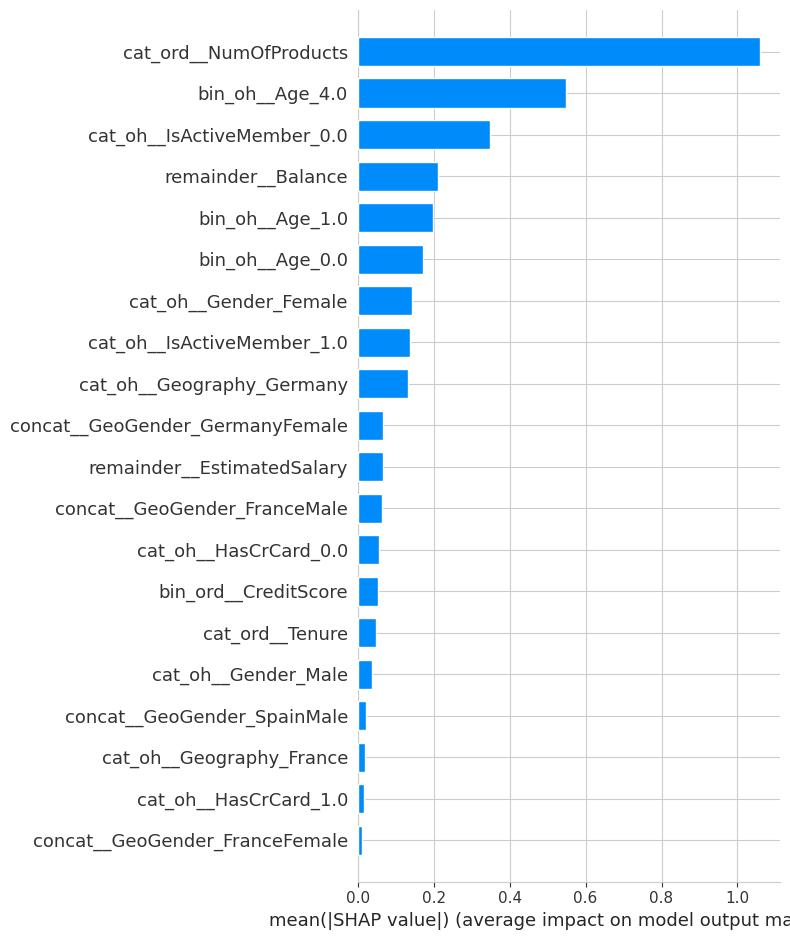

In [47]:
# Summary plot
shap.summary_plot(shap_values, X_train_pre, feature_names=X_train_pre.columns, plot_type="bar")  
plt.show()

### Cat Boost

Tips: increase the number of folds during HPO (for the big dataset) can achieve the higher accuracy

- Observation: the default CatBoost model (with `iteration=1000`) works better on this dataset (`AUC=0.88434` on private score) in compare with the fine-tuned hype-parameters using Optuna (`AUC=0.88323` on private score)
    - 3 CatBoost with different bootstrap type each: no bootstrap, Bayesian, and Bernoulli,
- `class_weight` to ask model to pay attention on the minority class
    - For example: `{"0": 1, "1": 5}` since the `class=1` is the minority class, so we can assign a stronger penalty (in this case is 5) to the model when it fails to detect a true positive (Exiter). 

In [ ]:
def objective(trial):
    param = {
        #"task_type": "GPU",
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        #"used_ram_limit": "3gb",
        "eval_metric": "AUC", # TODO: need to update
    }

#     if param["bootstrap_type"] == "Bayesian":
#         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif param["bootstrap_type"] == "Bernoulli":
#         param["subsample"] = trial.suggest_float("subsample", 0.1, 1)


    kfold = StratifiedKFold(n_splits=20, shuffle=True, random_state=2024)
    # follow the cross validation in optuna: 
    # https://www.kaggle.com/code/iqbalsyahakbar/ps4e1-3rd-place-solution#CatBoost
    model = CatBoostClassifier(**param, verbose=False)
    roc_auc = np.round(
                    np.mean(
                        cross_val_score(model, X_train_pre, y_train,
                        scoring="roc_auc", cv=kfold)
                    ), 3
                )
    return roc_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
cat_model = CatBoostClassifier(
                #**study.best_trial.params, 
                eval_metric='AUC',
                #class_weights={"0": 1, "1": 5},
                iterations=1000
)

cat_model.fit(X_train_pre,
              y_train,
              eval_set=(X_val_pre,y_val),
              verbose=False
             )

### Light GBM
6 hyper-parameters require for LightGBM
- `num_iterations` number of trees
    - The more trees you have, the more stable your predictions will be
    - How many trees should you choose: 
        - If your model needs to deliver results with low latency, you might want to limit the number of trees to around 200.
        - If your model runs once a week (e.g.: sales forecasting) and has more time to make the predictions, you could consider using up to 5,000 trees
- `learning_rate` 
    - Rule of thumb: start by fixing the number of trees and then focus on tuning the learning_rate
    - The more trees you have, the smaller the learning rate should be.
    - Range: 0.001 and 0.1 (`trial.suggest_float("learning_rate", 1e-3, 0.1, log=True)`)
- `num_leaves` maximum number of terminal nodes (leaves) that can be present in each tree.
    - num_leaves is equivalent to `max_depth` parameter in other tree-based models
    - In a decision tree, a leaf represents a decision or an outcome.
    - Range: powers of 2, starting from 2 and going up to 1024
    - Pros: By increasing the num_leaves, you allow the tree to grow more complex, creating a higher number of distinct decision paths.
    - Cons: increasing the number of leaves may also cause the model to **overfit** the training data, as it will have a lower amount of data per leaf.
- `subsample`  control the amount of data used for building each tree in your model.
    - Range: a fraction that ranges from 0 to 1, representing the proportion of the dataset to be randomly selected for training each tree (Recommend: 0.05 and 1)
    - By using only a subset of the data for each tree, the model can benefit from the diversity and reduce the correlation between the trees, which may help combat overfitting.
- `bagging_freq` is the frequency at which the data is sampled.    
    - Rule of thumb: to set bagging_freq to a **positive** value or LightGBM will ignore `subsample`.
- `colsample_bytree` determines the proportion of features to be used for each tree.
    - Range:  from 0 to 1, where a value of 1 means that all features will be considered for every tree
- `min_data_in_leaf`  sets the minimum number of data points that must be present in a leaf node in each tree.
    - This parameter helps control the complexity of the model and prevents overfitting.
    - Range: 1 to 100
    - If you have a leaf node with only 1 data point, your prediction will be the value of that single data point.
    - If you have a leaf node with 30 data points, your prediction will be the average of those 30 data points.
#### LGBM vs Random Forest
- The `subsample` and `colsample_bytree` hyperparameters in LightGBM make it similar to Random Forests in some ways, as the Random Forests samples rows (with replacement) and columns for each tree.
- LightGBM is a gradient boosting method, while Random Forests is a bagging method, which means they learn from the data in different ways.

#### Observation:
- Default LightGBM works better then the one that is fine-tuned.


In [ ]:
def objective(trial):
    param = {
        "objective": "regression",
        "metric": "auc",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }


    # Fit the model
    model = LGBMClassifier(**param)
    model.fit(X_train_pre,
                y_train,
                eval_set=[(X_val_pre, y_val)])

    # Make predictions
    y_pred_proba = model.predict_proba(X_val_pre)[:, 1]
    # Evaluate predictions
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return roc_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
# LightGBM Parameters
# lgbParams = {'n_estimators': 1000,
#              'max_depth': 25, 
#              'learning_rate': 0.025,
#              'min_child_weight': 3.43,
#              'min_child_samples': 216, 
#              'subsample': 0.782,
#              'subsample_freq': 4, 
#              'colsample_bytree': 0.29, 
#              'num_leaves': 21}
lgb_model = LGBMClassifier()
lgb_model.fit(X_train_pre,
            y_train,
            eval_metric='auc',
            eval_set=[(X_val_pre, y_val)])

In [ ]:
# import lightgbm as lgb
# lgb.plot_importance(lgb_model, importance_type="gain", figsize=(8,6), max_num_features=12, color = "black",
#                     title="LightGBM Feature Importance (Gain)")
# plt.show()
# evaluate_model(lgb_model, X_val_pre, y_val)

## Submission

In [ ]:
def generate_results(models, X_test):
    X_test_pre = full_pipeline.transform(X_test)
    for model in models:
        submission_data["Exited"] = model.predict_proba(X_test_pre)[: ,1]
        submission_data.to_csv(f"{model.__class__.__name__}_result.csv", index=False)
    if len(models) > 1:
        submission_data["Exited"] = np.mean([model.predict_proba(X_test_pre)[: ,1] for model in models], axis=0)
        submission_data.to_csv("stacked_result.csv", index=False)

#generate_results([clf_xgb, cat_model, lgb_model], df_test)
generate_results([clf_xgb], df_test)